<a href="https://colab.research.google.com/github/keerthireddy-28/ExplainableAi/blob/main/LAB_EXAM_2263ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Preprocessing

In [45]:
# load libraries
import pandas as pd
import numpy as np
df = pd.read_csv('heart.csv')
print(df.shape)
df.head()


(1025, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


#Min-Max Scaling

In [46]:
from sklearn.preprocessing import MinMaxScaler

# separate features and target
X = df.drop('target', axis=1)
y = df['target']

# Min-Max scaling
scaler = MinMaxScaler()
X_minmax = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)



#Z-Score (Standardization)


In [47]:
from sklearn.preprocessing import StandardScaler

scaler_std = StandardScaler()
X_standard = pd.DataFrame(scaler_std.fit_transform(X), columns=X.columns)


#Null Value Handling (Missing Data)

In [48]:
# check missing
print(df.isnull().sum())

# 1) Drop rows with any missing values (only if small fraction):
df_drop = df.dropna()

# 2) Drop columns with many missing values:
df2 = df.drop(columns=['col_with_many_nans'], errors='ignore')

from sklearn.impute import SimpleImputer
num_cols = df.select_dtypes(include=[np.number]).columns
cat_cols = df.select_dtypes(exclude=[np.number]).columns

imp_median = SimpleImputer(strategy='median')
df[num_cols] = imp_median.fit_transform(df[num_cols])

imp_mode = SimpleImputer(strategy='most_frequent')
if len(cat_cols) > 0:
    df[cat_cols] = imp_mode.fit_transform(df[cat_cols])


age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


#Imbalance / Balance Handling

In [50]:
# only run if class imbalance is significant
y.value_counts(normalize=True)


try:
    from imblearn.over_sampling import SMOTE
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X_minmax, y)   # use scaled features (minmax or std)
except Exception as e:
    print("imblearn not available; fallback to using original X and y:", e)
    X_res, y_res = X_minmax, y


#Correlation Analysis

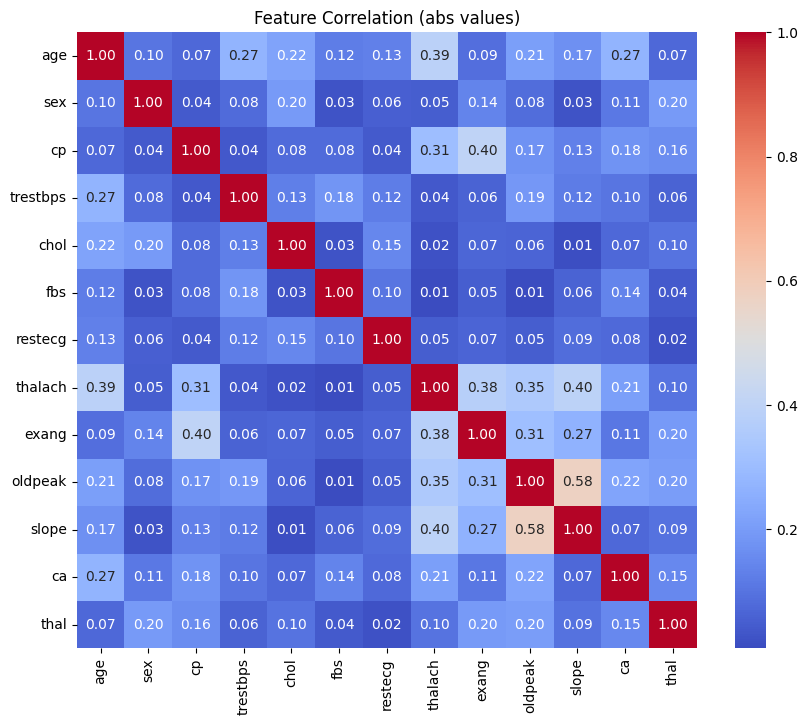

To drop due to high correlation: []


In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

# use scaled features for correlation (X_minmax or X_standard)
corr = X_minmax.corr().abs()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlation (abs values)')
plt.show()

# Drop highly correlated (simple heuristic):
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.85)]
print("To drop due to high correlation:", to_drop)

# Create reduced feature set:
X_corr_reduced = X_minmax.drop(columns=to_drop, errors='ignore')


#SHAP

In [68]:
!pip install shap
try:
    import shap
    # train a tree model (RandomForest) quickly
    from sklearn.ensemble import RandomForestClassifier

    # Determine which feature set and target to use based on whether SMOTE was applied
    if 'X_res' in globals() and 'y_res' in globals():
        # If SMOTE was applied, select the reduced columns from the resampled features
        X_for_training = X_res.drop(columns=to_drop, errors='ignore')
        y_for_training = y_res
    else:
        # If SMOTE was not applied, use the correlation-reduced features and original target
        X_for_training = X_corr_reduced
        y_for_training = y

    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_for_training, y_for_training)
    print("RandomForest trained.")

    # Tree SHAP
    explainer = shap.Explainer(rf, X_for_training)
    # Use a sample of the training data for SHAP values
    sample_size = min(300, X_for_training.shape[0])
    sample_indices = np.random.choice(X_for_training.shape[0], size=sample_size, replace=False)
    sample_X = X_for_training.iloc[sample_indices]
    sample_y = y_for_training.iloc[sample_indices]

    shap_values = explainer(sample_X)

    # global importance (mean abs SHAP)
    mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
    shap_importance = pd.Series(mean_abs_shap, index=X_for_training.columns).sort_values(ascending=False)
    print("Top SHAP features:\n", shap_importance.head(10))

    # visualize summary
    shap.summary_plot(shap_values, sample_X)   # interactive

except Exception as e:
    print("SHAP unavailable or failed:", e)
    # fallback - permutation importance
    from sklearn.inspection import permutation_importance

    # Use the same feature set and target as for SHAP
    if 'X_res' in globals() and 'y_res' in globals():
        X_for_training = X_res.drop(columns=to_drop, errors='ignore')
        y_for_training = y_res
    else:
        X_for_training = X_corr_reduced
        y_for_training = y

    rf = RandomForestClassifier(n_estimators=200, random_state=42)
    rf.fit(X_for_training, y_for_training)

    perm = permutation_importance(rf, X_for_training, y_for_training, n_repeats=10, random_state=42)
    perm_importance = pd.Series(perm.importances_mean, index=X_for_training.columns).sort_values(ascending=False)
    print("Top permutation importance features:\n", perm_importance.head(10))

RandomForest trained.
SHAP unavailable or failed: Data must be 1-dimensional, got ndarray of shape (13, 2) instead
Top permutation importance features:
 cp          0.065114
ca          0.063213
thal        0.037928
oldpeak     0.017015
sex         0.011407
exang       0.011027
age         0.010646
chol        0.007795
thalach     0.003422
trestbps    0.002757
dtype: float64


#Visualization Techniques

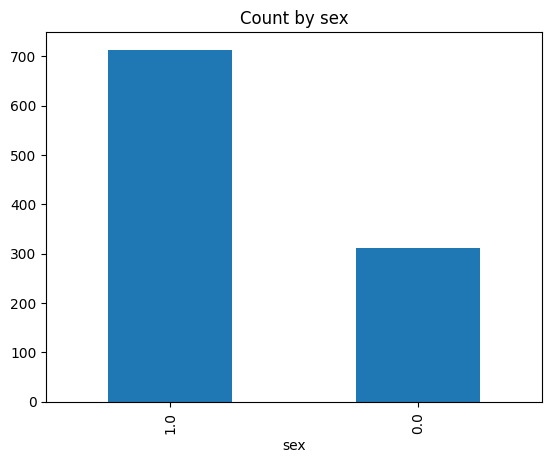

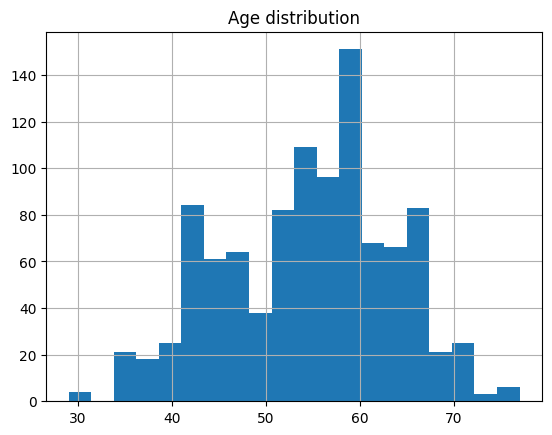

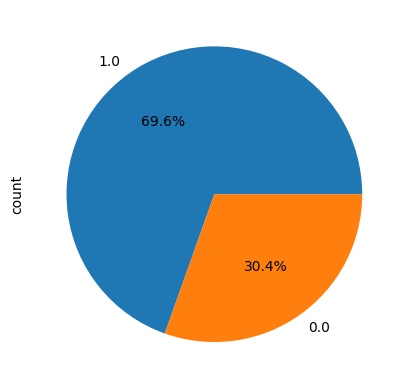

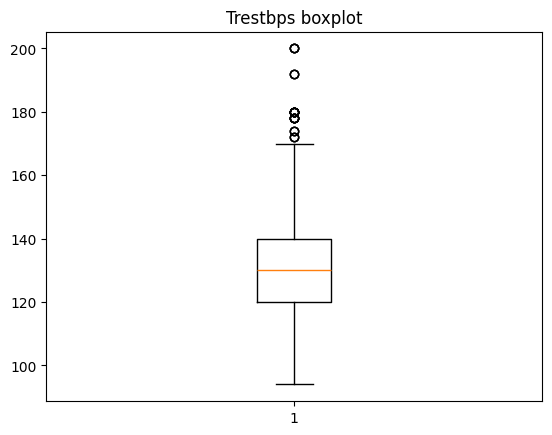

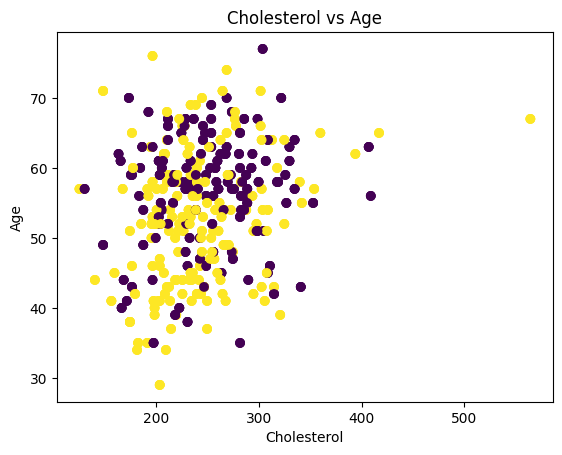

In [54]:
# Bar chart (categorical counts)
df['sex'].value_counts().plot(kind='bar')
plt.title('Count by sex')
plt.show()

# Histogram (numeric distribution)
df['age'].hist(bins=20)
plt.title('Age distribution')
plt.show()

# Pie chart (percentage male/female)
df['sex'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.show()

# Box plot (outliers)
plt.boxplot(df['trestbps'].dropna())
plt.title('Trestbps boxplot')
plt.show()

# Scatter plot (two numeric)
plt.scatter(df['chol'], df['age'], c=df['target'])
plt.xlabel('Cholesterol')
plt.ylabel('Age')
plt.title('Cholesterol vs Age')
plt.show()


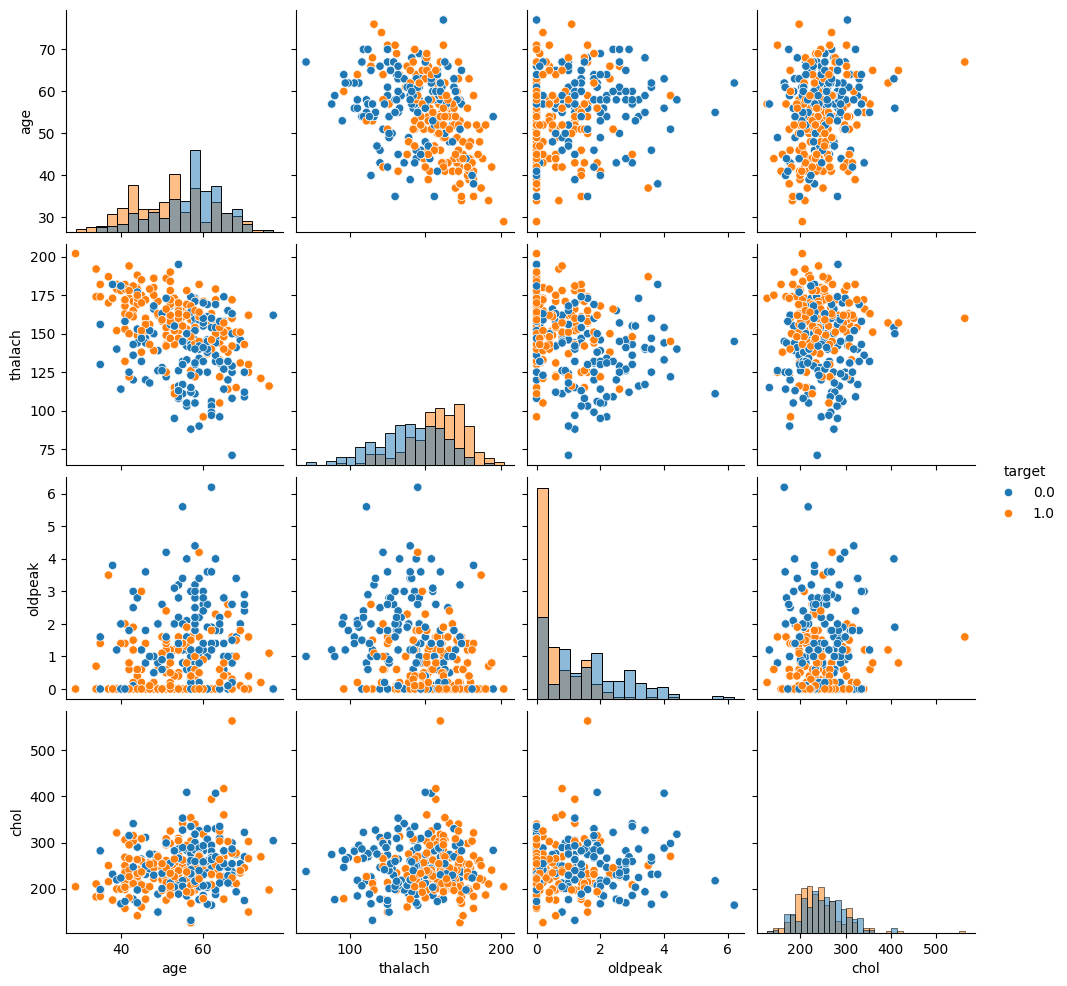

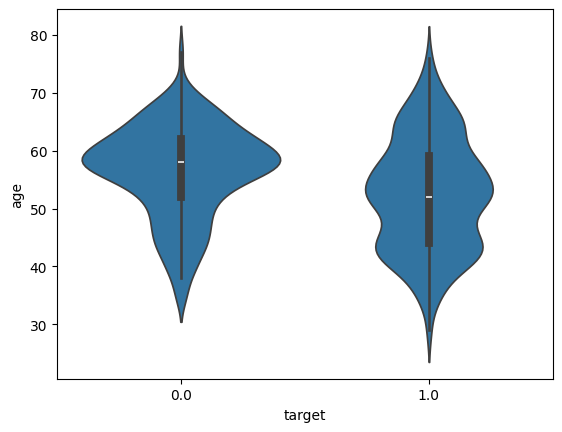

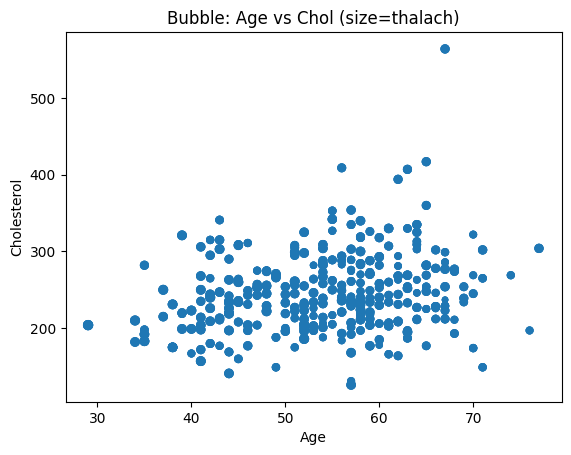

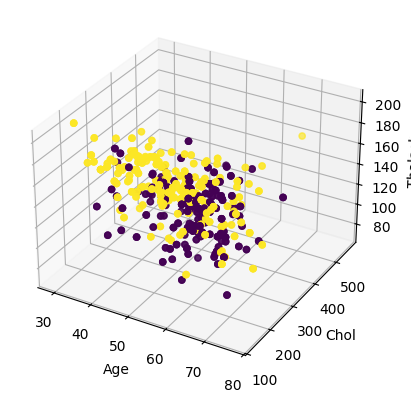

In [55]:
# Heatmap (correlation) - already shown above

# Pairplot (seaborn) - for small number of features
import seaborn as sns
sns.pairplot(df[['age','thalach','oldpeak','chol','target']], hue='target', diag_kind='hist')
plt.show()

# Violin plot
sns.violinplot(x='target', y='age', data=df)
plt.show()

# Bubble chart (age vs chol, bubble=size by thalach)
plt.scatter(df['age'], df['chol'], s=(df['thalach']*0.2))
plt.xlabel('Age')
plt.ylabel('Cholesterol')
plt.title('Bubble: Age vs Chol (size=thalach)')
plt.show()

# 3D scatter
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['age'], df['chol'], df['thalach'], c=df['target'])
ax.set_xlabel('Age'); ax.set_ylabel('Chol'); ax.set_zlabel('Thalach')
plt.show()


#Machine Learning Models

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import pandas as pd

if 'top_features' in globals() and 'X_res' in globals():
    X_model_for_split = X_res[top_features]
    y_for_split = y_res
elif 'X_res' in globals():

    X_model_for_split = X_res
    y_for_split = y_res
else:
    # If SMOTE was not applied, use the correlation-reduced features or original minmax scaled features
    X_model_for_split = X_corr_reduced if 'X_corr_reduced' in globals() else X_minmax
    y_for_split = y


# Use the selected feature set and target for splitting
X_train, X_test, y_train, y_test = train_test_split(X_model_for_split, y_for_split,
                                                    test_size=0.2, random_state=42, stratify=y_for_split)

models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'GaussianNB': GaussianNB(),
    'SVM': SVC(probability=True, random_state=42)
}

results = {}
for name, m in models.items():
    m.fit(X_train, y_train)
    y_pred = m.predict(X_test)
    y_prob = m.predict_proba(X_test)[:,1] if hasattr(m, 'predict_proba') else None
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None
    cm = confusion_matrix(y_test, y_pred)
    results[name] = {'accuracy':acc, 'precision':prec, 'recall':rec, 'f1':f1, 'auc':auc, 'confusion_matrix':cm}

# print summary table
pd.DataFrame(results).T[['accuracy','precision','recall','f1','auc']]

,accuracy,precision,recall,f1,auc
LogisticRegression,0.834123,0.801724,0.885714,0.841629,0.919137
DecisionTree,0.985782,1.0,0.971429,0.985507,0.985714
KNN,0.848341,0.861386,0.828571,0.84466,0.962084
GaussianNB,0.843602,0.815789,0.885714,0.849315,0.904852
SVM,0.890995,0.894231,0.885714,0.889952,0.956065


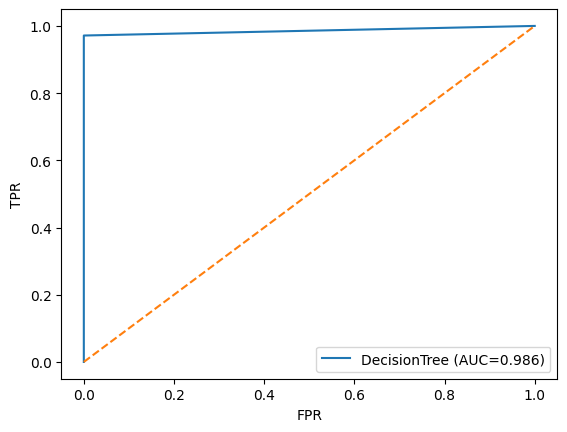

In [58]:
# select model with highest AUC
best = max([(k, v['auc']) for k,v in results.items() if v['auc'] is not None], key=lambda x: x[1])[0]
best_model = models[best]
y_prob = best_model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f'{best} (AUC={results[best]["auc"]:.3f})')
plt.plot([0,1],[0,1],'--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.legend(); plt.show()


#Ensemble Machine Learning Algorithms

In [65]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
# RandomForest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# ExtraTrees
et = ExtraTreesClassifier(n_estimators=200, random_state=42)
et.fit(X_train, y_train)

# AdaBoost / GradientBoosting
adb = AdaBoostClassifier(n_estimators=100, random_state=42)
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
adb.fit(X_train, y_train); gb.fit(X_train, y_train)

# Voting ensemble (hard or soft)
voting = VotingClassifier(estimators=[('lr', models['LogisticRegression']), ('rf', rf), ('gb', gb)], voting='soft')
voting.fit(X_train, y_train)

# Evaluate (same metrics as above)
for name, model in [('RF', rf), ('ET', et), ('AdaBoost', adb), ('GB', gb), ('Voting', voting)]:
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1] if hasattr(model, 'predict_proba') else None
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None

    # Format AUC value conditionally
    auc_display = f"{auc:.4f}" if auc is not None else 'N/A'

    print(f"{name} - Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, AUC: {auc_display}")



RF - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000, AUC: 1.0000
ET - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000, AUC: 1.0000
AdaBoost - Accuracy: 0.8815, Precision: 0.8704, Recall: 0.8952, F1: 0.8826, AUC: 0.9512
GB - Accuracy: 0.9668, Precision: 0.9712, Recall: 0.9619, F1: 0.9665, AUC: 0.9894
Voting - Accuracy: 0.9810, Precision: 0.9810, Recall: 0.9810, F1: 0.9810, AUC: 0.9984


#Deep Learning Algorithms

MLP accuracy: 0.985781990521327
AUC: 0.9998203054806828
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Classification Report (Keras MLP):
              precision    recall  f1-score   support

           0      1.000     0.972     0.986       106
           1      0.972     1.000     0.986       105

    accuracy                          0.986       211
   macro avg      0.986     0.986     0.986       211
weighted avg      0.986     0.986     0.986       211



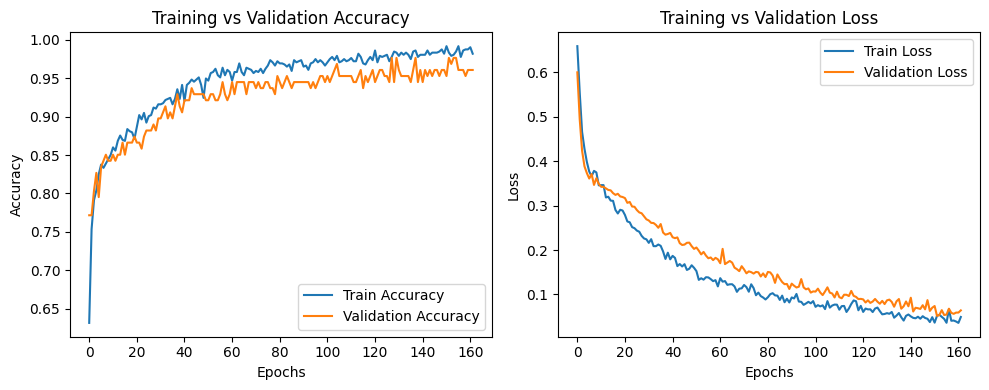

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


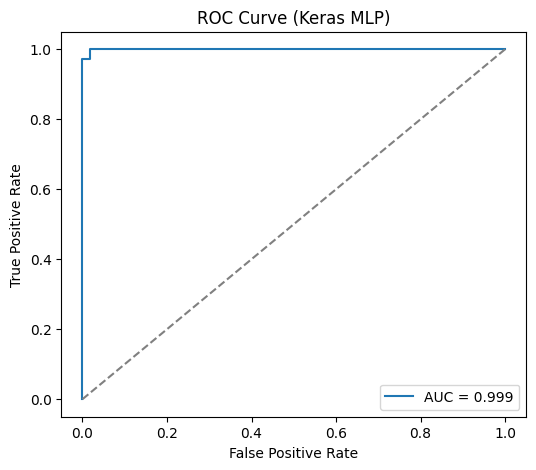

In [67]:
# ===============================
# sklearn + Keras MLP Example
# ===============================
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# ===== sklearn MLP =====
mlp = MLPClassifier(hidden_layer_sizes=(128, 64), activation='relu', solver='adam', max_iter=500, random_state=42)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
probs = mlp.predict_proba(X_test)[:, 1]

print("MLP accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, probs))

# ===== Keras MLP =====
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, validation_split=0.15, epochs=200, batch_size=32, callbacks=[es], verbose=0)

# ===== Classification Report =====
y_pred_keras = (model.predict(X_test) > 0.5).astype(int)
print("\nClassification Report (Keras MLP):")
print(classification_report(y_test, y_pred_keras, digits=3))

# ===== Plot Training vs Validation Accuracy and Loss =====
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend()
plt.tight_layout()
plt.show()

# ===== ROC Curve =====
y_pred_prob = model.predict(X_test).ravel()
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Keras MLP)')
plt.legend()
plt.show()
